In [1]:
import pandas
import numpy
from matplotlib import pyplot
import os
import ROOT

Welcome to JupyROOT 6.24/06


In [2]:
times = {"taskid":[],"mean":[],"meanerr":[],"throughput_MB_s":[]}
maindir = "20211115-16corespernode-nopinning"
timedirs = [timedir for timedir in os.listdir(maindir) if timedir.startswith("timeresults")]

dfs = []
for timedir in timedirs:
    nodes = int(timedir.split("_")[2].replace("nodes",""))
    corespernode = int(timedir.split("_")[3].replace("corespernode",""))
    chunks = nodes*corespernode
    for f in os.listdir(os.path.join(maindir, timedir)):
        df = pandas.read_csv(os.path.join(maindir, timedir, f), header=None, names=["taskruntime","taskreadtime","readthroughput","readpayload"], skiprows=1)
        taskid = int(f.split("_")[1].replace("task",""))
        df["taskid"] = int(taskid)
        df["nodes"] = int(nodes)
        df["chunks"] = int(chunks)
        dfs.append(df)

df = pandas.concat(dfs).sort_values(by="nodes").reset_index(drop=True)
df

,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes,chunks
0,20.320,18955739674,372,7058797284,14,1,16
1,22.126,20790929042,339,7058797416,7,1,16
2,22.793,20339841279,347,7058797416,7,1,16
3,22.090,21159715575,333,7058797416,7,1,16
4,21.520,20609858194,342,7058797416,7,1,16
...,...,...,...,...,...,...,...
3019,5.117,4572495936,257,1176466104,78,6,96
3020,6.345,5666877905,207,1176466104,78,6,96
3021,5.496,5002059946,235,1176466104,78,6,96
3022,5.397,4674421530,251,1176466236,20,6,96


In [3]:
meantaskthroughput = df.groupby(["chunks"]).mean()
meantaskthroughput = meantaskthroughput.reset_index().sort_values("chunks").reset_index(drop=True)
meantaskthroughput


,chunks,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes
0,16,21.325326,2.007788e+10,351.472222,7.058797e+09,7.5,1.0
1,32,13.147694,1.256352e+10,281.121528,3.529399e+09,15.5,2.0
2,48,9.532988,8.994935e+09,261.532407,2.352932e+09,23.5,3.0
3,64,7.304714,6.756731e+09,261.664931,1.764699e+09,31.5,4.0
4,80,5.825482,5.260574e+09,268.440278,1.411759e+09,39.5,5.0
5,96,5.298667,4.694404e+09,253.625000,1.176466e+09,47.5,6.0


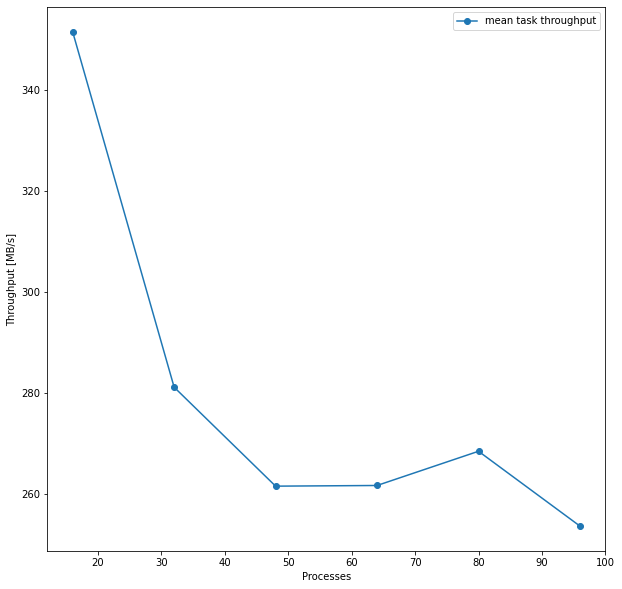

In [4]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["chunks"], meantaskthroughput["readthroughput"], label="mean task throughput", marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput [MB/s]")
pyplot.legend()

In [5]:
sumthroughput = df.groupby(["chunks","nodes","taskid"]).mean()
sumthroughput = sumthroughput.reset_index().groupby(["chunks","nodes"]).sum()
sumthroughput = sumthroughput.reset_index()
sumthroughput["totalthroughput"] = sumthroughput["readthroughput"] / 1024
sumthroughput

,chunks,nodes,taskid,taskruntime,taskreadtime,readthroughput,readpayload,totalthroughput
0,16,1,120,341.205222,3.212461e+11,5623.555556,1.129408e+11,5.491753
1,32,2,496,420.726222,4.020326e+11,8995.888889,1.129408e+11,8.785048
2,48,3,1128,457.583444,4.317569e+11,12553.555556,1.129408e+11,12.259332
3,64,4,2016,467.501667,4.324308e+11,16746.555556,1.129408e+11,16.354058
4,80,5,3160,466.038556,4.208459e+11,21475.222222,1.129408e+11,20.971897
5,96,6,4560,508.672000,4.506628e+11,24348.000000,1.129408e+11,23.777344


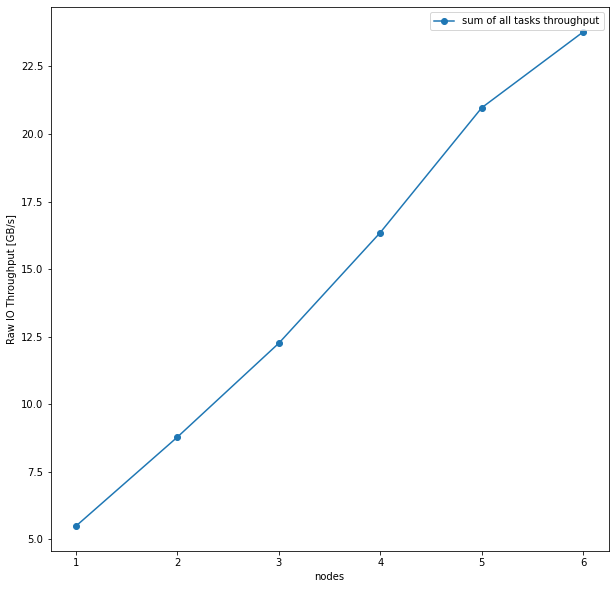

In [6]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["nodes"], sumthroughput["totalthroughput"], label="sum of all tasks throughput", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Raw IO Throughput [GB/s]")
pyplot.legend()

# Python timer

In [7]:
times = {"nodes":[],"meanruntime":[], "err":[], "throughput_MB_s":[]}
timedir = "20211115-16corespernode-nopinning/appruntimes"
datasetsize = 157400503680
readpercent = 0.7949011466389114
readsize = datasetsize * readpercent # taken from the RNTuple metrics above

for f in os.listdir(timedir):
    array = numpy.genfromtxt(os.path.join(timedir, f), skip_header=2)
    nodes = f.split("_")[5].replace("nodes","")
    time_mean = numpy.mean(array)
    times["nodes"].append(int(nodes))
    times["meanruntime"].append(round(time_mean, 2))
    times["err"].append(round(numpy.std(array)/numpy.sqrt(len(array)), 2))
    times["throughput_MB_s"].append(round(readsize/time_mean/pow(10,6)))
    
timesdf = pandas.DataFrame(times)
timesdf = timesdf.sort_values(by="nodes").reset_index(drop=True).copy()
throughput_1node = timesdf["throughput_MB_s"][0]
time_1node = timesdf["meanruntime"][0]
timesdf["runtimespeedup"] = time_1node / timesdf["meanruntime"]
timesdf["throughputspeedup"] = timesdf["throughput_MB_s"] / throughput_1node
timesdf

,nodes,meanruntime,err,throughput_MB_s,runtimespeedup,throughputspeedup
0,1,22.15,0.27,5649,1.000000,1.000000
1,2,13.85,0.23,9034,1.599278,1.599221
2,3,10.15,0.13,12326,2.182266,2.181979
3,4,7.88,0.14,15884,2.810914,2.811825
4,5,6.39,0.05,19585,3.466354,3.466985
5,6,5.96,0.20,20993,3.716443,3.716233


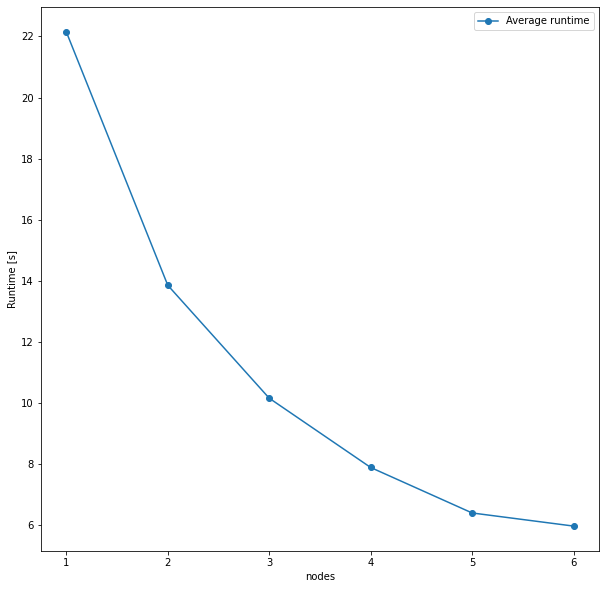

In [8]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["meanruntime"], label="Average runtime", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Runtime [s]")
pyplot.legend()

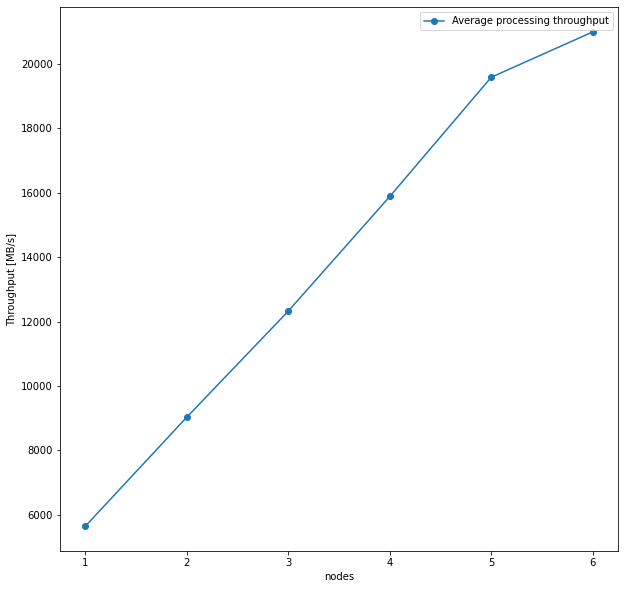

In [9]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughput_MB_s"], label="Average processing throughput", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Throughput [MB/s]")
pyplot.legend()

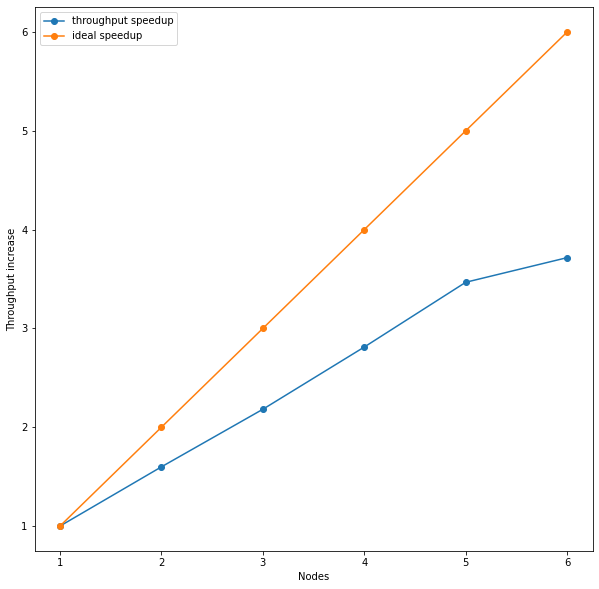

In [10]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughputspeedup"], label="throughput speedup", marker="o")
pyplot.plot(timesdf["nodes"], timesdf["nodes"], label="ideal speedup", marker="o")
pyplot.xticks(timesdf["nodes"])
pyplot.yticks(timesdf["nodes"])
pyplot.xlabel("Nodes")
pyplot.ylabel("Throughput increase")
pyplot.legend()